In [2]:
library(tidyverse)
library(repr)
library(tidymodels)
library(cowplot)
options(repr.matrix.max.rows = 6)

                    Can Age Predict Player Engagement on a Research Game Server

In today’s data-driven research environment, player behavior data offers valuable insights for understanding user engagement and optimizing resource allocation. A computer science research team at UBC has established a research server on the Minecraft platform to collect behavioral data from players as they navigate the virtual world. To enhance data quality and research efficiency, the team aims to identify which players are more likely to contribute a large amount of data—that is, those who spend more time on the server. Centered around this goal, the present project poses the following research question: Can a player's age effectively predict their gameplay time? In this context, contributing a large amount of data is typically measured by the number of hours a player spends in the game, while the "type" of player refers to those with observable characteristics such as age. The dataset used for this analysis contains 196 observations, each representing one player. It includes 7 variables in total. Specifically, experience is the player's self-assessed gaming level, categorized as "Amateur," "Pro," or "Veteran"; subscribe indicates whether the player subscribed to the research newsletter (a logical variable); played_hours is the total number of hours a player spent on the server, and serves as the response variable in this study; Age is the player's self-reported age and the main explanatory variable; gender is the player's selected gender. The dataset also contains name and hashedEmail, which are identifying fields not used in modeling. During data preprocessing, we found that the Age column contained missing values, so records with missing ages were removed prior to modeling. Overall, this dataset is well-structured and reasonably complete, providing a solid foundation to explore the research question of whether age can predict gameplay time.

To investigate whether a player's age can predict their gameplay time on the research server, this study employed a linear regression model for modeling and analysis. The analysis workflow consisted of several key steps: data import, preprocessing, data splitting, model construction, prediction visualization, and performance evaluation. The researcher first used the read_delim() function to import the raw dataset players.csv, and selected the core variables: Age (player's age) and played_hours (total gameplay time). Since the Age column contained missing values, all incomplete records were removed prior to modeling to ensure data quality. Next, the initial_split() function was used to divide the data into a 75% training set and a 25% testing set, with the strata = played_hours parameter ensuring stratified sampling consistency based on gameplay time distribution. During the modeling phase, the tidymodels framework was employed to construct a linear regression model. The recipe() function was used to preprocess the explanatory variable Age by centering and scaling it, in order to eliminate the impact of variable magnitude on model estimation. The regression model itself was defined using the linear_reg() function with the engine set to "lm" (linear model), and it was combined with the recipe into a workflow() for model fitting on the training data. Once model fitting was completed, predictions were made on both the training and testing sets. The ggplot2 package was used to visualize the prediction trends and compare them against the actual values using fitted plots. Finally, the RMSE on the testing set was calculated to quantify the accuracy of the model's predictions.
Below is the code:

mean_hours
<dbl>
5.904639


[1] 9.51121

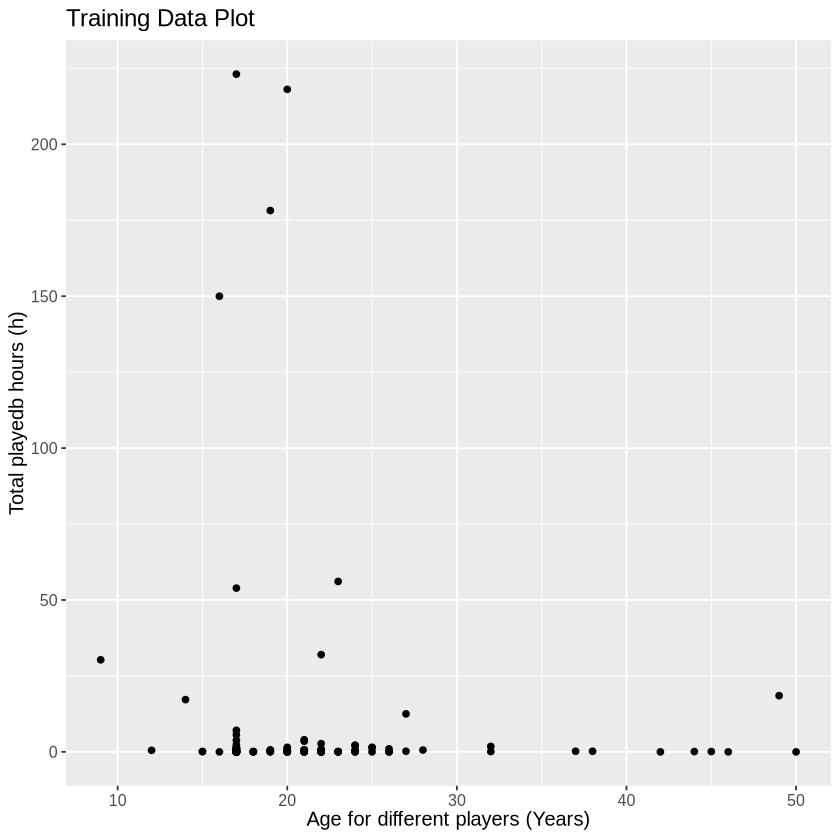

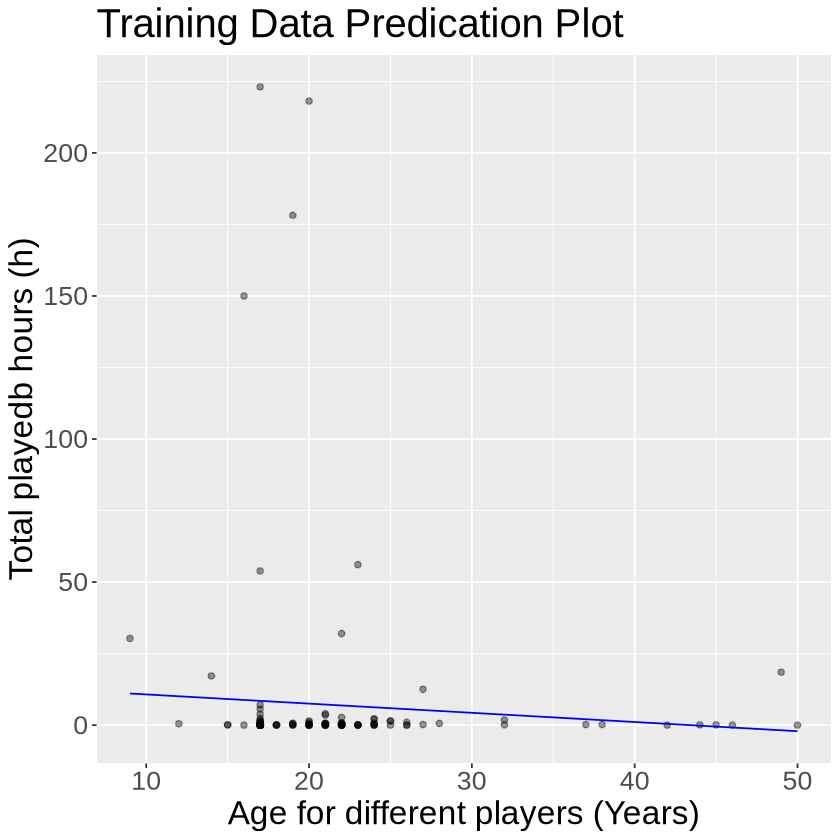

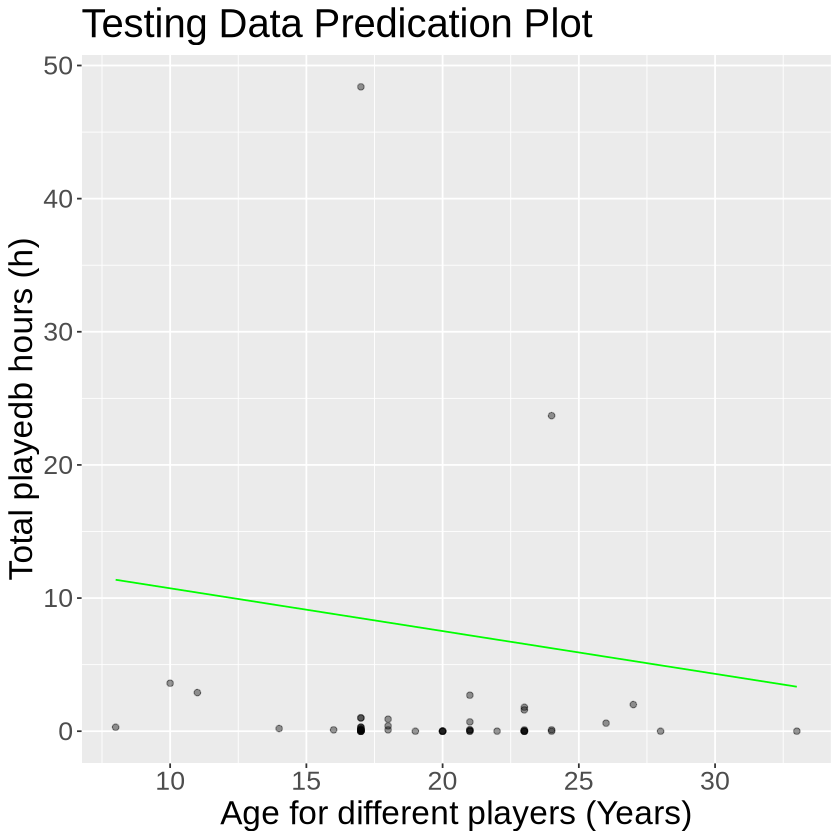

In [3]:
set.seed(627)
player_data <- read_delim("players.csv", delim = " ", col_names = TRUE, show_col_types = FALSE)
clean_data <- player_data |> 
  select(played_hours, Age) |>       
  filter(!is.na(Age)) |>               
  as_tibble()
mean_play_hours <- clean_data |>
  summarize(mean_hours = mean(played_hours))
player_split <- initial_split(clean_data, prop = 0.75, strata = played_hours)
player_training <- training(player_split)
player_testing <- testing(player_split)
training_plot <- ggplot(player_training, aes(x = Age, y = played_hours)) +
           geom_point() +
           xlab("Age for different players (Years)") +
           ylab("Total playedb hours (h)") +
           labs(title = "Training Data Plot") +
           theme(text = element_text(size = 12))
player_spec <- linear_reg() |>
  set_engine("lm") |>
  set_mode("regression")
player_recipe <- recipe(played_hours ~ Age, data = player_training) |>
             step_center(all_predictors()) |>
             step_scale(all_predictors())
player_fit <- workflow() |>
       add_recipe(player_recipe) |>
       add_model(player_spec) |>
       fit(data = player_training)
player_preds <- player_fit |>
   predict(player_training) |>
   bind_cols(player_training)
player_predictions <- player_preds |>
     ggplot(aes(x = Age, y = played_hours)) +
         geom_point(alpha = 0.4) +
         geom_line(
             mapping = aes(x = Age, y = .pred), 
             color = "blue") +
         xlab("Age for different players (Years)") +
         ylab("Total playedb hours (h)") +
         labs(title = "Training Data Predication Plot") +
         theme(text = element_text(size = 20))


player_test_results <- player_fit |>
         predict(player_testing) |>
         bind_cols(player_testing) |>
         metrics(truth = played_hours, estimate = .pred)
player_rmspe <- player_test_results |>
          filter(.metric == "rmse") |>
          select(.estimate) |>
          pull()
test_preds <-  player_fit |> predict(player_testing) |>
              bind_cols(player_testing)
player_predictions_test <- test_preds |>
     ggplot(aes(x = Age, y = played_hours)) +
         geom_point(alpha = 0.4) +
         geom_line(
             mapping = aes(x = Age, y = .pred), 
             color = "green") +
         xlab("Age for different players (Years)") +
         ylab("Total playedb hours (h)") +
         labs(title = "Testing Data Predication Plot") +
         theme(text = element_text(size = 20))
mean_play_hours 
player_rmspe
training_plot 
player_predictions
player_predictions_test

The linear regression model is suitable for this study because it can describe the linear relationship between an explanatory variable and a continuous response variable. Its structure is straightforward, easy to interpret, and the prediction results can be directly quantified. Moreover, linear regression relies on several assumptions: a linear relationship between variables, independently and identically distributed errors, and homoscedasticity. In this study, since only one explanatory variable, Age, is involved, multicollinearity is not a concern. However, linear models also have limitations. If the relationship between variables is nonlinear or the data contains outliers, the model’s fitting ability may be compromised. More importantly, a univariate model may not capture the full complexity of player behavior. Therefore, future research should consider incorporating more variables and potentially nonlinear modeling techniques. In this study, only a basic univariate linear regression model was constructed for comparison, and the model was selected based on its direct relevance to the research question and its interpretability. Predictive performance was evaluated using RMSE, which quantifies the prediction error on the testing set. While simple, this method provides an initial quantitative basis for understanding the potential impact of age on gameplay activity.

According to the results of the linear regression model, the regression line shows a slight negative slope, indicating a weak trend where older players tend to play slightly less. However, this trend is minimal, and the data distribution is highly scattered, with many outliers and a concentration of points at low playtime levels. More importantly, the RMSE on the test set is 9.5, which is significantly higher than the average playtime across all players (approximately 5.9 hours), suggesting the model’s prediction error is large and the predictive power is practically negligible. Therefore, despite a weak negative correlation, age does not effectively predict how long players will play. This result deviates somewhat from the initial expectation. It was hypothesized that age, as a social-behavioral indicator, might correlate with playtime, for instance, younger players might have more free time, while older players might be restricted by work or study commitments. However, the findings show that age alone offers very limited explanatory power, suggesting that player behavior is likely driven by other factors such as level of interest, motivation, gaming skill, or social network involvement. These findings have important implications for data-driven recruitment strategies. If age is used as the sole indicator to identify high-contributing players, the results may be ineffective. Therefore, future research should explore additional factors that influence player engagement, particularly psychological motives, skill level, and the type of device used.